# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

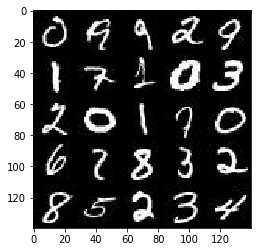

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

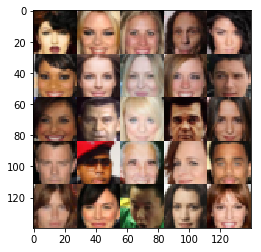

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    l_rate = tf.placeholder(tf.float32, (None), name='learning_rate')

    return inputs, z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 128, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        x1 = tf.layers.dense(z, 4*4*512)
    
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        #x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        #x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.maximum(alpha * x4, x4)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim=z_dim)
    l_rate = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    
    #figsize=(5,5)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.7f}...".format(train_loss_d),
                          "Generator Loss: {:.7f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 12, input_z, data_shape[3], data_image_mode)
                    
                    #gen_samples = sess.run(
                    #               generator(input_z, 3, reuse=True, training=False),
                    #               feed_dict={input_z: sample_z})
                    #samples.append(gen_samples)
                    #_ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    #plt.show()
                    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9838762... Generator Loss: 13.2613373
Epoch 1/2... Discriminator Loss: 0.5359592... Generator Loss: 14.3869705
Epoch 1/2... Discriminator Loss: 0.9939387... Generator Loss: 2.2658916
Epoch 1/2... Discriminator Loss: 2.6415539... Generator Loss: 4.6654806
Epoch 1/2... Discriminator Loss: 0.9500486... Generator Loss: 1.4788553
Epoch 1/2... Discriminator Loss: 0.4712287... Generator Loss: 2.7996759
Epoch 1/2... Discriminator Loss: 0.9277482... Generator Loss: 3.3130314
Epoch 1/2... Discriminator Loss: 1.5810336... Generator Loss: 5.6579041
Epoch 1/2... Discriminator Loss: 0.9760468... Generator Loss: 1.2020302
Epoch 1/2... Discriminator Loss: 3.5089509... Generator Loss: 7.7603464


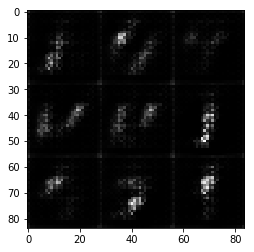

Epoch 1/2... Discriminator Loss: 1.1137706... Generator Loss: 2.6562769
Epoch 1/2... Discriminator Loss: 0.8893210... Generator Loss: 3.3372087
Epoch 1/2... Discriminator Loss: 0.9839495... Generator Loss: 1.4018056
Epoch 1/2... Discriminator Loss: 0.7759209... Generator Loss: 1.6073763
Epoch 1/2... Discriminator Loss: 0.8162692... Generator Loss: 2.5436268
Epoch 1/2... Discriminator Loss: 1.7543436... Generator Loss: 0.8376294
Epoch 1/2... Discriminator Loss: 1.0656087... Generator Loss: 0.9276290
Epoch 1/2... Discriminator Loss: 1.0049965... Generator Loss: 1.0004256
Epoch 1/2... Discriminator Loss: 0.9854409... Generator Loss: 1.0963634
Epoch 1/2... Discriminator Loss: 0.8251141... Generator Loss: 1.4779428


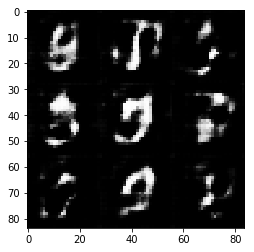

Epoch 1/2... Discriminator Loss: 0.9394761... Generator Loss: 1.2327251
Epoch 1/2... Discriminator Loss: 0.8765813... Generator Loss: 1.7611841
Epoch 1/2... Discriminator Loss: 1.2829340... Generator Loss: 2.1151237
Epoch 1/2... Discriminator Loss: 1.1183319... Generator Loss: 1.2477034
Epoch 1/2... Discriminator Loss: 1.0759616... Generator Loss: 0.9624144
Epoch 1/2... Discriminator Loss: 1.2180318... Generator Loss: 0.8375558
Epoch 1/2... Discriminator Loss: 1.8762927... Generator Loss: 0.3868077
Epoch 1/2... Discriminator Loss: 1.0996871... Generator Loss: 1.4149151
Epoch 1/2... Discriminator Loss: 1.0319090... Generator Loss: 0.9512817
Epoch 1/2... Discriminator Loss: 1.4393568... Generator Loss: 2.2511423


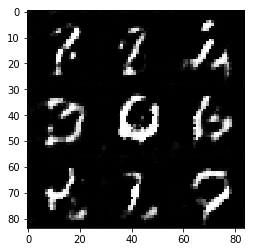

Epoch 1/2... Discriminator Loss: 1.2245995... Generator Loss: 2.6098232
Epoch 1/2... Discriminator Loss: 0.9273213... Generator Loss: 1.5516671
Epoch 1/2... Discriminator Loss: 0.9976049... Generator Loss: 1.5681720
Epoch 1/2... Discriminator Loss: 1.9304630... Generator Loss: 3.6123853
Epoch 1/2... Discriminator Loss: 0.9889883... Generator Loss: 1.0902723
Epoch 1/2... Discriminator Loss: 1.2889137... Generator Loss: 0.6666833
Epoch 1/2... Discriminator Loss: 1.0829513... Generator Loss: 1.8185985
Epoch 1/2... Discriminator Loss: 1.0250111... Generator Loss: 1.5082819
Epoch 1/2... Discriminator Loss: 1.7544003... Generator Loss: 2.9949460
Epoch 1/2... Discriminator Loss: 1.1340140... Generator Loss: 0.8182756


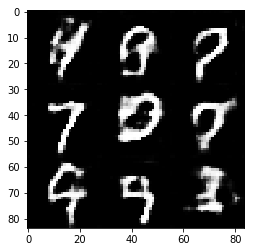

Epoch 1/2... Discriminator Loss: 1.1583856... Generator Loss: 0.7669402
Epoch 1/2... Discriminator Loss: 1.1777318... Generator Loss: 0.7455859
Epoch 1/2... Discriminator Loss: 1.2238257... Generator Loss: 0.7178315
Epoch 1/2... Discriminator Loss: 1.2210202... Generator Loss: 2.5027013
Epoch 1/2... Discriminator Loss: 1.0367899... Generator Loss: 1.0207692
Epoch 1/2... Discriminator Loss: 1.0980779... Generator Loss: 0.8473150
Epoch 2/2... Discriminator Loss: 0.9506785... Generator Loss: 1.2138835
Epoch 2/2... Discriminator Loss: 0.9683349... Generator Loss: 1.6614003
Epoch 2/2... Discriminator Loss: 0.9801335... Generator Loss: 1.2281132
Epoch 2/2... Discriminator Loss: 1.0499901... Generator Loss: 1.0610441


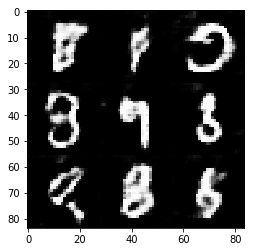

Epoch 2/2... Discriminator Loss: 1.5705172... Generator Loss: 0.4449663
Epoch 2/2... Discriminator Loss: 1.0334866... Generator Loss: 1.4850763
Epoch 2/2... Discriminator Loss: 1.5276455... Generator Loss: 0.4446517
Epoch 2/2... Discriminator Loss: 1.0057856... Generator Loss: 1.2532873
Epoch 2/2... Discriminator Loss: 1.0857790... Generator Loss: 0.8235760
Epoch 2/2... Discriminator Loss: 0.9927378... Generator Loss: 1.4383206
Epoch 2/2... Discriminator Loss: 0.9353402... Generator Loss: 1.1549376
Epoch 2/2... Discriminator Loss: 0.9514332... Generator Loss: 1.2554619
Epoch 2/2... Discriminator Loss: 1.4112371... Generator Loss: 0.5939785
Epoch 2/2... Discriminator Loss: 1.0740712... Generator Loss: 0.8636179


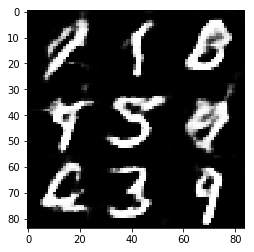

Epoch 2/2... Discriminator Loss: 1.1911420... Generator Loss: 2.0145011
Epoch 2/2... Discriminator Loss: 1.0812500... Generator Loss: 0.9211669
Epoch 2/2... Discriminator Loss: 0.9739949... Generator Loss: 1.8658040
Epoch 2/2... Discriminator Loss: 1.3753867... Generator Loss: 0.5368781
Epoch 2/2... Discriminator Loss: 0.9460657... Generator Loss: 1.2109364
Epoch 2/2... Discriminator Loss: 1.1178164... Generator Loss: 1.7711272
Epoch 2/2... Discriminator Loss: 0.9916697... Generator Loss: 1.3969245
Epoch 2/2... Discriminator Loss: 4.2276969... Generator Loss: 5.9703102
Epoch 2/2... Discriminator Loss: 1.0837680... Generator Loss: 0.8154470
Epoch 2/2... Discriminator Loss: 1.1660370... Generator Loss: 2.5689282


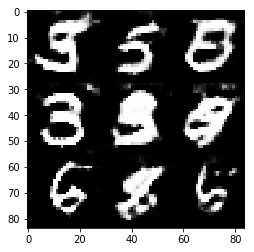

Epoch 2/2... Discriminator Loss: 0.9381220... Generator Loss: 1.2540164
Epoch 2/2... Discriminator Loss: 1.0505106... Generator Loss: 1.2036090
Epoch 2/2... Discriminator Loss: 1.3913407... Generator Loss: 2.6607232
Epoch 2/2... Discriminator Loss: 0.9114943... Generator Loss: 1.6672097
Epoch 2/2... Discriminator Loss: 1.5003234... Generator Loss: 0.5129117
Epoch 2/2... Discriminator Loss: 0.9458842... Generator Loss: 1.6587927
Epoch 2/2... Discriminator Loss: 0.9592896... Generator Loss: 1.0398884
Epoch 2/2... Discriminator Loss: 1.3933437... Generator Loss: 1.8864074
Epoch 2/2... Discriminator Loss: 1.1143003... Generator Loss: 1.1435990
Epoch 2/2... Discriminator Loss: 1.2139187... Generator Loss: 0.7640606


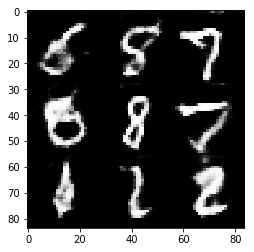

Epoch 2/2... Discriminator Loss: 1.0091912... Generator Loss: 1.1617159
Epoch 2/2... Discriminator Loss: 1.0057774... Generator Loss: 0.9382831
Epoch 2/2... Discriminator Loss: 1.1585979... Generator Loss: 1.8282676
Epoch 2/2... Discriminator Loss: 1.4537954... Generator Loss: 0.4858100
Epoch 2/2... Discriminator Loss: 1.0405774... Generator Loss: 0.9663471
Epoch 2/2... Discriminator Loss: 1.9118490... Generator Loss: 0.3170030
Epoch 2/2... Discriminator Loss: 1.1633849... Generator Loss: 1.4260367
Epoch 2/2... Discriminator Loss: 1.2698603... Generator Loss: 1.2327027
Epoch 2/2... Discriminator Loss: 1.1033003... Generator Loss: 1.2052491
Epoch 2/2... Discriminator Loss: 0.9227068... Generator Loss: 1.4556960


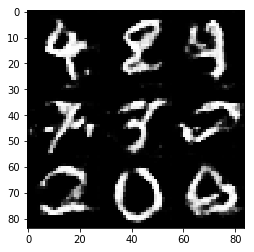

Epoch 2/2... Discriminator Loss: 1.3702265... Generator Loss: 2.3859067
Epoch 2/2... Discriminator Loss: 1.2658845... Generator Loss: 0.6730068
Epoch 2/2... Discriminator Loss: 0.8187439... Generator Loss: 1.5494790


IndexError: list index out of range

In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/4... Discriminator Loss: 2.9229903... Generator Loss: 0.1198607
Epoch 1/4... Discriminator Loss: 0.5311574... Generator Loss: 8.7201080
Epoch 1/4... Discriminator Loss: 1.8748491... Generator Loss: 20.7582798
Epoch 1/4... Discriminator Loss: 0.4811642... Generator Loss: 5.6954288
Epoch 1/4... Discriminator Loss: 1.7293736... Generator Loss: 15.0424385
Epoch 1/4... Discriminator Loss: 0.9049399... Generator Loss: 2.5259261
Epoch 1/4... Discriminator Loss: 1.3085009... Generator Loss: 1.1155574
Epoch 1/4... Discriminator Loss: 1.0318310... Generator Loss: 6.6534429
Epoch 1/4... Discriminator Loss: 0.6253170... Generator Loss: 5.5834827
Epoch 1/4... Discriminator Loss: 0.6177697... Generator Loss: 2.5720177


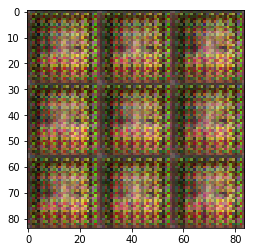

Epoch 1/4... Discriminator Loss: 0.5460429... Generator Loss: 2.3926442
Epoch 1/4... Discriminator Loss: 0.4696603... Generator Loss: 3.0336325
Epoch 1/4... Discriminator Loss: 0.4915138... Generator Loss: 2.3670981
Epoch 1/4... Discriminator Loss: 0.4559286... Generator Loss: 3.0729611
Epoch 1/4... Discriminator Loss: 0.7092417... Generator Loss: 1.4361659
Epoch 1/4... Discriminator Loss: 0.5063093... Generator Loss: 2.6753416
Epoch 1/4... Discriminator Loss: 0.6647578... Generator Loss: 1.5804521
Epoch 1/4... Discriminator Loss: 0.7076087... Generator Loss: 1.8034046
Epoch 1/4... Discriminator Loss: 0.5757388... Generator Loss: 1.9710650
Epoch 1/4... Discriminator Loss: 0.6866593... Generator Loss: 1.6228164


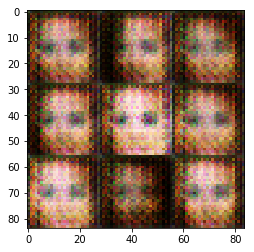

Epoch 1/4... Discriminator Loss: 0.6835765... Generator Loss: 2.5504584
Epoch 1/4... Discriminator Loss: 0.5514727... Generator Loss: 2.3831749
Epoch 1/4... Discriminator Loss: 0.6460835... Generator Loss: 2.6562901
Epoch 1/4... Discriminator Loss: 0.7518373... Generator Loss: 1.4745198
Epoch 1/4... Discriminator Loss: 1.4268243... Generator Loss: 6.0396037
Epoch 1/4... Discriminator Loss: 0.6642110... Generator Loss: 2.0066733
Epoch 1/4... Discriminator Loss: 0.7535484... Generator Loss: 3.7265787
Epoch 1/4... Discriminator Loss: 0.6025029... Generator Loss: 2.2130804
Epoch 1/4... Discriminator Loss: 0.6739153... Generator Loss: 2.0262375
Epoch 1/4... Discriminator Loss: 0.7946649... Generator Loss: 2.8609211


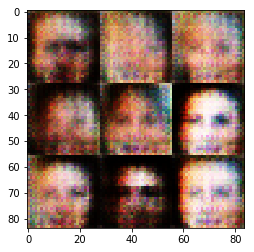

Epoch 1/4... Discriminator Loss: 0.9644071... Generator Loss: 1.2630551
Epoch 1/4... Discriminator Loss: 0.9597695... Generator Loss: 1.2657954
Epoch 1/4... Discriminator Loss: 1.1009940... Generator Loss: 0.9083897
Epoch 1/4... Discriminator Loss: 0.8342801... Generator Loss: 1.9462219
Epoch 1/4... Discriminator Loss: 0.7468441... Generator Loss: 2.6981936
Epoch 1/4... Discriminator Loss: 1.1176473... Generator Loss: 4.5513144
Epoch 1/4... Discriminator Loss: 0.8598564... Generator Loss: 1.3123381
Epoch 1/4... Discriminator Loss: 0.6959642... Generator Loss: 2.0642653
Epoch 1/4... Discriminator Loss: 0.7214777... Generator Loss: 2.7356222
Epoch 1/4... Discriminator Loss: 0.9353770... Generator Loss: 1.1837468


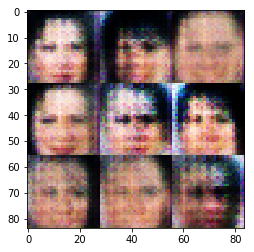

Epoch 1/4... Discriminator Loss: 0.8037493... Generator Loss: 1.3787658
Epoch 1/4... Discriminator Loss: 0.6306044... Generator Loss: 2.5323403
Epoch 1/4... Discriminator Loss: 1.6223650... Generator Loss: 0.5360390
Epoch 1/4... Discriminator Loss: 0.9499288... Generator Loss: 3.2310414
Epoch 1/4... Discriminator Loss: 0.7833778... Generator Loss: 1.2888571
Epoch 1/4... Discriminator Loss: 0.8528323... Generator Loss: 1.4935379
Epoch 1/4... Discriminator Loss: 0.6941043... Generator Loss: 1.8943111
Epoch 1/4... Discriminator Loss: 0.9007938... Generator Loss: 1.2274822
Epoch 1/4... Discriminator Loss: 0.7278145... Generator Loss: 1.7265892
Epoch 1/4... Discriminator Loss: 0.6457038... Generator Loss: 1.9951930


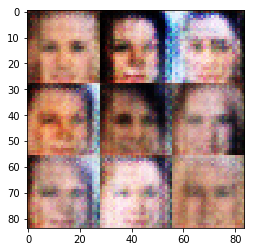

Epoch 1/4... Discriminator Loss: 0.7349733... Generator Loss: 2.0831149
Epoch 1/4... Discriminator Loss: 0.9184018... Generator Loss: 1.1553915
Epoch 1/4... Discriminator Loss: 0.7992259... Generator Loss: 2.3589993
Epoch 1/4... Discriminator Loss: 0.8469368... Generator Loss: 2.7377896
Epoch 1/4... Discriminator Loss: 0.7913347... Generator Loss: 1.3254668
Epoch 1/4... Discriminator Loss: 0.8715990... Generator Loss: 2.8001661
Epoch 1/4... Discriminator Loss: 0.6747953... Generator Loss: 1.7858763
Epoch 1/4... Discriminator Loss: 1.2387305... Generator Loss: 3.1494236
Epoch 1/4... Discriminator Loss: 1.1219882... Generator Loss: 2.7569132
Epoch 1/4... Discriminator Loss: 2.5863731... Generator Loss: 5.1644969


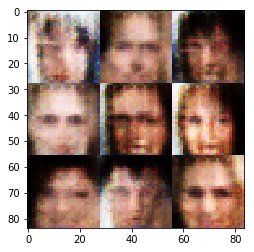

Epoch 1/4... Discriminator Loss: 0.9488930... Generator Loss: 1.1600193
Epoch 1/4... Discriminator Loss: 1.0211891... Generator Loss: 0.9488202
Epoch 1/4... Discriminator Loss: 0.9834989... Generator Loss: 1.5890863
Epoch 1/4... Discriminator Loss: 1.0210581... Generator Loss: 1.1500828
Epoch 1/4... Discriminator Loss: 0.9672052... Generator Loss: 1.1179280
Epoch 1/4... Discriminator Loss: 0.8500167... Generator Loss: 1.3508202
Epoch 1/4... Discriminator Loss: 1.7911630... Generator Loss: 4.1335678
Epoch 1/4... Discriminator Loss: 0.8679489... Generator Loss: 1.2570720
Epoch 1/4... Discriminator Loss: 1.0090585... Generator Loss: 2.3583689
Epoch 1/4... Discriminator Loss: 1.1284341... Generator Loss: 0.8820213


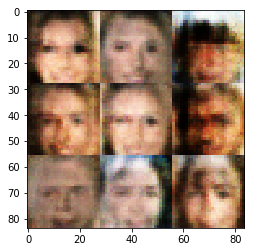

Epoch 1/4... Discriminator Loss: 1.0504626... Generator Loss: 3.2580724
Epoch 1/4... Discriminator Loss: 1.1289961... Generator Loss: 0.8461142
Epoch 1/4... Discriminator Loss: 0.9931992... Generator Loss: 1.1439729
Epoch 1/4... Discriminator Loss: 0.8387961... Generator Loss: 1.5318483
Epoch 1/4... Discriminator Loss: 0.9569919... Generator Loss: 1.0912083
Epoch 1/4... Discriminator Loss: 0.7437228... Generator Loss: 2.5297012
Epoch 1/4... Discriminator Loss: 0.9047513... Generator Loss: 2.2118793
Epoch 1/4... Discriminator Loss: 0.9216355... Generator Loss: 1.6992375
Epoch 1/4... Discriminator Loss: 0.9744849... Generator Loss: 1.1737249
Epoch 1/4... Discriminator Loss: 0.9305295... Generator Loss: 1.2705405


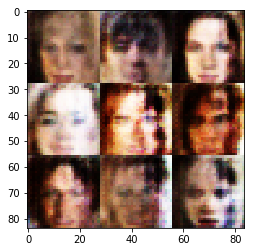

Epoch 1/4... Discriminator Loss: 1.1081694... Generator Loss: 2.6778302
Epoch 1/4... Discriminator Loss: 0.7728113... Generator Loss: 1.4637542
Epoch 1/4... Discriminator Loss: 1.0733030... Generator Loss: 0.8711846
Epoch 1/4... Discriminator Loss: 0.8837589... Generator Loss: 1.9719267
Epoch 1/4... Discriminator Loss: 0.8240354... Generator Loss: 1.6559945
Epoch 1/4... Discriminator Loss: 0.7829171... Generator Loss: 1.7573754
Epoch 1/4... Discriminator Loss: 0.8293940... Generator Loss: 1.3748044
Epoch 1/4... Discriminator Loss: 0.7458247... Generator Loss: 1.4644315
Epoch 1/4... Discriminator Loss: 1.0225793... Generator Loss: 1.6827009
Epoch 1/4... Discriminator Loss: 0.9577551... Generator Loss: 1.0772446


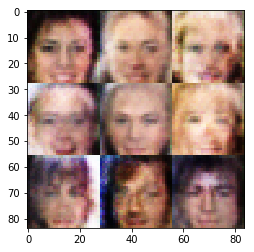

Epoch 1/4... Discriminator Loss: 0.8402253... Generator Loss: 1.3429601
Epoch 1/4... Discriminator Loss: 0.9885255... Generator Loss: 2.5072024
Epoch 1/4... Discriminator Loss: 0.8311799... Generator Loss: 1.5609361
Epoch 1/4... Discriminator Loss: 0.8225081... Generator Loss: 1.3931512
Epoch 1/4... Discriminator Loss: 0.9180903... Generator Loss: 1.1806014
Epoch 1/4... Discriminator Loss: 1.0508367... Generator Loss: 1.2094719
Epoch 1/4... Discriminator Loss: 1.0716301... Generator Loss: 0.8140500
Epoch 1/4... Discriminator Loss: 0.9524797... Generator Loss: 2.6034117
Epoch 1/4... Discriminator Loss: 0.8027924... Generator Loss: 1.9534047
Epoch 1/4... Discriminator Loss: 0.8347977... Generator Loss: 1.5027909


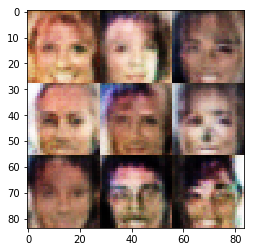

Epoch 1/4... Discriminator Loss: 1.0127696... Generator Loss: 0.8865514
Epoch 1/4... Discriminator Loss: 0.7069043... Generator Loss: 1.6501575
Epoch 1/4... Discriminator Loss: 1.4062988... Generator Loss: 0.5116558
Epoch 1/4... Discriminator Loss: 0.8706279... Generator Loss: 1.9965162
Epoch 1/4... Discriminator Loss: 1.2075145... Generator Loss: 0.6534315
Epoch 1/4... Discriminator Loss: 1.0104362... Generator Loss: 0.9939273
Epoch 1/4... Discriminator Loss: 0.8849463... Generator Loss: 2.2937222
Epoch 1/4... Discriminator Loss: 0.8583373... Generator Loss: 1.9025140
Epoch 1/4... Discriminator Loss: 1.0059646... Generator Loss: 2.7328465
Epoch 1/4... Discriminator Loss: 1.0576094... Generator Loss: 0.8242524


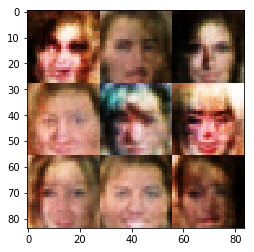

Epoch 1/4... Discriminator Loss: 0.7640734... Generator Loss: 2.3196945
Epoch 1/4... Discriminator Loss: 0.9056411... Generator Loss: 2.0496619
Epoch 1/4... Discriminator Loss: 0.5337861... Generator Loss: 2.3711586
Epoch 1/4... Discriminator Loss: 0.8141756... Generator Loss: 3.5031569
Epoch 1/4... Discriminator Loss: 0.9349583... Generator Loss: 1.2893087
Epoch 1/4... Discriminator Loss: 1.1198385... Generator Loss: 0.7559952
Epoch 1/4... Discriminator Loss: 0.9541928... Generator Loss: 1.0746787
Epoch 1/4... Discriminator Loss: 0.9382780... Generator Loss: 0.9882495
Epoch 1/4... Discriminator Loss: 0.8098408... Generator Loss: 1.2609258
Epoch 1/4... Discriminator Loss: 0.6696966... Generator Loss: 1.9122565


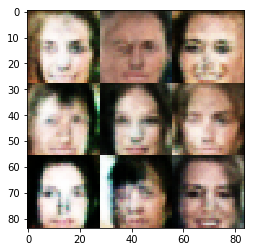

Epoch 1/4... Discriminator Loss: 0.6764524... Generator Loss: 2.4630053
Epoch 1/4... Discriminator Loss: 0.9212204... Generator Loss: 1.0528746
Epoch 1/4... Discriminator Loss: 0.7605306... Generator Loss: 1.7903434
Epoch 1/4... Discriminator Loss: 0.7542022... Generator Loss: 1.5471275
Epoch 1/4... Discriminator Loss: 0.9591672... Generator Loss: 2.2135859
Epoch 1/4... Discriminator Loss: 0.7114044... Generator Loss: 1.6034029
Epoch 1/4... Discriminator Loss: 0.7132166... Generator Loss: 1.6965877
Epoch 1/4... Discriminator Loss: 0.9997076... Generator Loss: 0.8944250
Epoch 1/4... Discriminator Loss: 0.7473477... Generator Loss: 1.4958092
Epoch 1/4... Discriminator Loss: 1.0995593... Generator Loss: 0.8426653


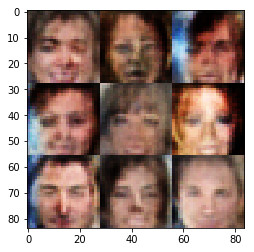

Epoch 1/4... Discriminator Loss: 1.4356817... Generator Loss: 2.9112401
Epoch 1/4... Discriminator Loss: 1.1733909... Generator Loss: 0.7609963
Epoch 1/4... Discriminator Loss: 0.7276900... Generator Loss: 1.8723205
Epoch 1/4... Discriminator Loss: 0.9639066... Generator Loss: 1.5909081
Epoch 1/4... Discriminator Loss: 0.8298897... Generator Loss: 1.8558340
Epoch 1/4... Discriminator Loss: 0.8200941... Generator Loss: 1.3080657
Epoch 1/4... Discriminator Loss: 1.8835344... Generator Loss: 0.4612289
Epoch 1/4... Discriminator Loss: 0.8388715... Generator Loss: 1.4856629
Epoch 1/4... Discriminator Loss: 0.8290861... Generator Loss: 1.2425479
Epoch 1/4... Discriminator Loss: 0.9311758... Generator Loss: 2.0183811


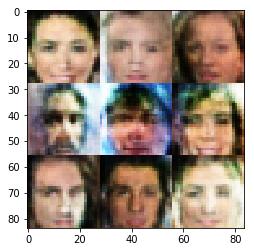

Epoch 1/4... Discriminator Loss: 0.7793961... Generator Loss: 1.4546286
Epoch 1/4... Discriminator Loss: 0.7342324... Generator Loss: 1.6150194
Epoch 1/4... Discriminator Loss: 0.6756582... Generator Loss: 1.6996417
Epoch 1/4... Discriminator Loss: 1.0453379... Generator Loss: 3.2386129
Epoch 1/4... Discriminator Loss: 0.7690797... Generator Loss: 1.4819092
Epoch 1/4... Discriminator Loss: 0.8876354... Generator Loss: 1.5094488
Epoch 1/4... Discriminator Loss: 1.0545752... Generator Loss: 1.0882912
Epoch 1/4... Discriminator Loss: 0.6773348... Generator Loss: 2.0987375
Epoch 1/4... Discriminator Loss: 1.1215553... Generator Loss: 0.7440347
Epoch 1/4... Discriminator Loss: 0.9611146... Generator Loss: 0.9508950


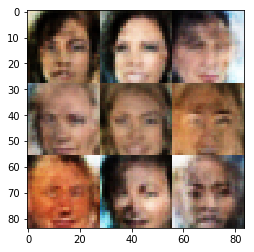

Epoch 1/4... Discriminator Loss: 0.7289433... Generator Loss: 1.4493525
Epoch 1/4... Discriminator Loss: 0.7967359... Generator Loss: 1.3479115
Epoch 1/4... Discriminator Loss: 0.8962187... Generator Loss: 1.9827647
Epoch 1/4... Discriminator Loss: 0.8469521... Generator Loss: 1.1258053
Epoch 1/4... Discriminator Loss: 0.9733676... Generator Loss: 0.8848435
Epoch 1/4... Discriminator Loss: 0.6368266... Generator Loss: 1.6822978
Epoch 1/4... Discriminator Loss: 0.7567583... Generator Loss: 2.4150007
Epoch 1/4... Discriminator Loss: 0.9097815... Generator Loss: 0.9829753
Epoch 2/4... Discriminator Loss: 0.8182521... Generator Loss: 1.5083818
Epoch 2/4... Discriminator Loss: 0.8057598... Generator Loss: 1.2385530


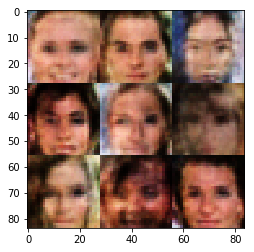

Epoch 2/4... Discriminator Loss: 0.7668166... Generator Loss: 1.6304452
Epoch 2/4... Discriminator Loss: 0.8940547... Generator Loss: 1.6707256
Epoch 2/4... Discriminator Loss: 0.6436529... Generator Loss: 1.9047862
Epoch 2/4... Discriminator Loss: 0.6890109... Generator Loss: 2.0633805
Epoch 2/4... Discriminator Loss: 0.8528280... Generator Loss: 1.4541392
Epoch 2/4... Discriminator Loss: 0.7973084... Generator Loss: 1.6581073
Epoch 2/4... Discriminator Loss: 1.0316498... Generator Loss: 1.5414402
Epoch 2/4... Discriminator Loss: 0.7037790... Generator Loss: 1.6423110
Epoch 2/4... Discriminator Loss: 1.0068673... Generator Loss: 1.9709442
Epoch 2/4... Discriminator Loss: 0.8891858... Generator Loss: 1.0552437


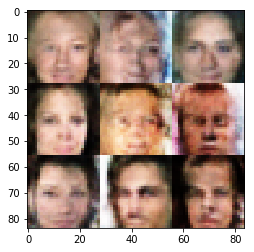

Epoch 2/4... Discriminator Loss: 0.8483686... Generator Loss: 1.1304761
Epoch 2/4... Discriminator Loss: 0.7461525... Generator Loss: 2.0724659
Epoch 2/4... Discriminator Loss: 1.7049663... Generator Loss: 0.3986548
Epoch 2/4... Discriminator Loss: 0.7171374... Generator Loss: 2.2473021
Epoch 2/4... Discriminator Loss: 0.6206473... Generator Loss: 2.5441124
Epoch 2/4... Discriminator Loss: 0.9519473... Generator Loss: 2.8906910
Epoch 2/4... Discriminator Loss: 0.7408699... Generator Loss: 2.1236582
Epoch 2/4... Discriminator Loss: 0.8582119... Generator Loss: 1.0387220
Epoch 2/4... Discriminator Loss: 1.3863146... Generator Loss: 0.5193935
Epoch 2/4... Discriminator Loss: 0.7328072... Generator Loss: 1.3961346


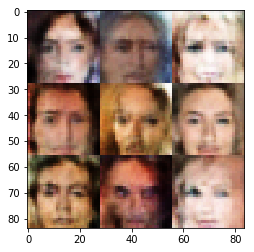

Epoch 2/4... Discriminator Loss: 1.0481713... Generator Loss: 0.8627689
Epoch 2/4... Discriminator Loss: 0.9352142... Generator Loss: 1.0813373
Epoch 2/4... Discriminator Loss: 0.7310741... Generator Loss: 1.4166939
Epoch 2/4... Discriminator Loss: 0.6512648... Generator Loss: 1.5481870
Epoch 2/4... Discriminator Loss: 0.9239115... Generator Loss: 0.9649999
Epoch 2/4... Discriminator Loss: 1.3542429... Generator Loss: 0.5394044
Epoch 2/4... Discriminator Loss: 1.1141951... Generator Loss: 0.7984632
Epoch 2/4... Discriminator Loss: 0.7905972... Generator Loss: 1.8595810
Epoch 2/4... Discriminator Loss: 0.6796418... Generator Loss: 2.1414189
Epoch 2/4... Discriminator Loss: 0.6838990... Generator Loss: 1.5393032


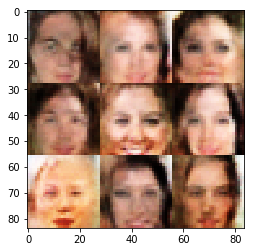

Epoch 2/4... Discriminator Loss: 1.0627576... Generator Loss: 0.8191563
Epoch 2/4... Discriminator Loss: 0.9769140... Generator Loss: 0.9259521
Epoch 2/4... Discriminator Loss: 0.6999042... Generator Loss: 2.0005176
Epoch 2/4... Discriminator Loss: 0.6382347... Generator Loss: 2.2361546
Epoch 2/4... Discriminator Loss: 0.7956537... Generator Loss: 1.3783754
Epoch 2/4... Discriminator Loss: 0.7692177... Generator Loss: 1.3111491
Epoch 2/4... Discriminator Loss: 0.8603708... Generator Loss: 1.2812108
Epoch 2/4... Discriminator Loss: 1.3386598... Generator Loss: 0.6222540
Epoch 2/4... Discriminator Loss: 0.9180901... Generator Loss: 1.2741538
Epoch 2/4... Discriminator Loss: 0.7117345... Generator Loss: 1.4212109


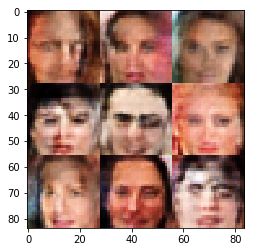

Epoch 2/4... Discriminator Loss: 0.9837471... Generator Loss: 0.8624290
Epoch 2/4... Discriminator Loss: 0.8329067... Generator Loss: 1.2656533
Epoch 2/4... Discriminator Loss: 0.7708001... Generator Loss: 1.3297546
Epoch 2/4... Discriminator Loss: 0.4659910... Generator Loss: 2.7666764
Epoch 2/4... Discriminator Loss: 0.8891405... Generator Loss: 2.1027081
Epoch 2/4... Discriminator Loss: 0.7465639... Generator Loss: 1.4705670
Epoch 2/4... Discriminator Loss: 0.9883574... Generator Loss: 0.9318511
Epoch 2/4... Discriminator Loss: 0.7172343... Generator Loss: 1.3042806
Epoch 2/4... Discriminator Loss: 0.7696202... Generator Loss: 1.2668788
Epoch 2/4... Discriminator Loss: 1.3909079... Generator Loss: 0.6276081


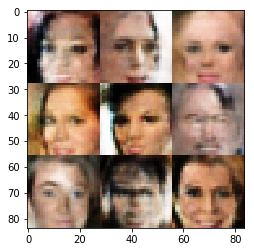

Epoch 2/4... Discriminator Loss: 0.7915735... Generator Loss: 2.0884452
Epoch 2/4... Discriminator Loss: 0.8129965... Generator Loss: 1.2741863
Epoch 2/4... Discriminator Loss: 0.7036366... Generator Loss: 1.6606814
Epoch 2/4... Discriminator Loss: 0.8718896... Generator Loss: 1.1400093
Epoch 2/4... Discriminator Loss: 0.5845501... Generator Loss: 2.5847397
Epoch 2/4... Discriminator Loss: 0.6631571... Generator Loss: 2.8336363
Epoch 2/4... Discriminator Loss: 0.7613131... Generator Loss: 2.9490962
Epoch 2/4... Discriminator Loss: 0.7966231... Generator Loss: 1.3935672
Epoch 2/4... Discriminator Loss: 1.6416248... Generator Loss: 0.5463705
Epoch 2/4... Discriminator Loss: 1.1741111... Generator Loss: 0.9971120


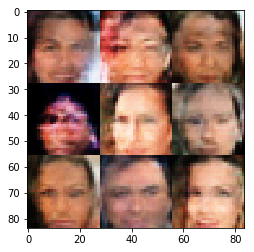

Epoch 2/4... Discriminator Loss: 0.8368183... Generator Loss: 1.2740165
Epoch 2/4... Discriminator Loss: 0.8627433... Generator Loss: 2.1858563
Epoch 2/4... Discriminator Loss: 0.6455605... Generator Loss: 1.7863693
Epoch 2/4... Discriminator Loss: 0.7048635... Generator Loss: 1.4494059
Epoch 2/4... Discriminator Loss: 0.9016323... Generator Loss: 3.1236858
Epoch 2/4... Discriminator Loss: 0.7701377... Generator Loss: 1.6622636
Epoch 2/4... Discriminator Loss: 0.7707373... Generator Loss: 1.3977770
Epoch 2/4... Discriminator Loss: 0.6091509... Generator Loss: 1.9763844
Epoch 2/4... Discriminator Loss: 0.7589024... Generator Loss: 2.7241945
Epoch 2/4... Discriminator Loss: 0.6227494... Generator Loss: 1.7535380


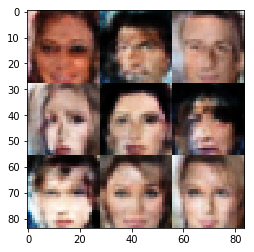

Epoch 2/4... Discriminator Loss: 0.5998610... Generator Loss: 2.9771073
Epoch 2/4... Discriminator Loss: 0.7281047... Generator Loss: 1.3758179
Epoch 2/4... Discriminator Loss: 0.8059043... Generator Loss: 1.1956005
Epoch 2/4... Discriminator Loss: 0.6634727... Generator Loss: 1.8741860
Epoch 2/4... Discriminator Loss: 0.9482796... Generator Loss: 3.2651243
Epoch 2/4... Discriminator Loss: 0.8247999... Generator Loss: 1.3030665
Epoch 2/4... Discriminator Loss: 0.6931894... Generator Loss: 1.7177963
Epoch 2/4... Discriminator Loss: 0.6901163... Generator Loss: 1.4293329
Epoch 2/4... Discriminator Loss: 0.8196910... Generator Loss: 1.1839677
Epoch 2/4... Discriminator Loss: 0.6366282... Generator Loss: 1.9891083


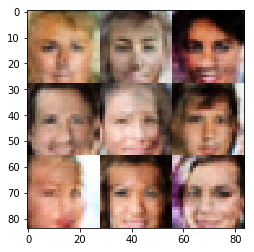

Epoch 2/4... Discriminator Loss: 0.7870400... Generator Loss: 1.1782094
Epoch 2/4... Discriminator Loss: 0.8497105... Generator Loss: 2.8287461
Epoch 2/4... Discriminator Loss: 0.6640830... Generator Loss: 1.5050640
Epoch 2/4... Discriminator Loss: 0.5231579... Generator Loss: 2.1251130
Epoch 2/4... Discriminator Loss: 0.6056708... Generator Loss: 1.7038596
Epoch 2/4... Discriminator Loss: 0.4826249... Generator Loss: 2.6839161
Epoch 2/4... Discriminator Loss: 0.6704071... Generator Loss: 2.5184309
Epoch 2/4... Discriminator Loss: 0.6257266... Generator Loss: 1.7462425
Epoch 2/4... Discriminator Loss: 0.6063393... Generator Loss: 1.9367682
Epoch 2/4... Discriminator Loss: 0.5236956... Generator Loss: 1.9633784


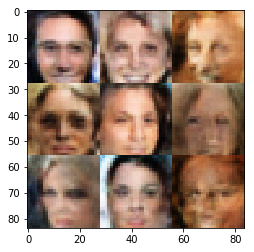

Epoch 2/4... Discriminator Loss: 2.0133421... Generator Loss: 4.8362398
Epoch 2/4... Discriminator Loss: 1.0555805... Generator Loss: 0.8235980
Epoch 2/4... Discriminator Loss: 0.7096493... Generator Loss: 1.3811734
Epoch 2/4... Discriminator Loss: 0.6764037... Generator Loss: 1.4540224
Epoch 2/4... Discriminator Loss: 0.6588719... Generator Loss: 1.5599810
Epoch 2/4... Discriminator Loss: 0.6882618... Generator Loss: 1.7234395
Epoch 2/4... Discriminator Loss: 2.2499988... Generator Loss: 0.2491255
Epoch 2/4... Discriminator Loss: 0.9473214... Generator Loss: 3.0999231
Epoch 2/4... Discriminator Loss: 0.6378188... Generator Loss: 1.5911876
Epoch 2/4... Discriminator Loss: 0.7521078... Generator Loss: 1.3601875


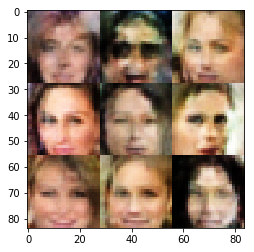

Epoch 2/4... Discriminator Loss: 1.3051984... Generator Loss: 0.6133482
Epoch 2/4... Discriminator Loss: 0.5786106... Generator Loss: 1.7936277
Epoch 2/4... Discriminator Loss: 0.6078913... Generator Loss: 3.0200148
Epoch 2/4... Discriminator Loss: 0.6224512... Generator Loss: 2.0237985
Epoch 2/4... Discriminator Loss: 0.6949908... Generator Loss: 1.4008341
Epoch 2/4... Discriminator Loss: 0.7532019... Generator Loss: 1.2752039
Epoch 2/4... Discriminator Loss: 2.1654980... Generator Loss: 6.1464624
Epoch 2/4... Discriminator Loss: 0.7898416... Generator Loss: 1.5884891
Epoch 2/4... Discriminator Loss: 0.8247318... Generator Loss: 1.1745658
Epoch 2/4... Discriminator Loss: 0.6747113... Generator Loss: 1.6981552


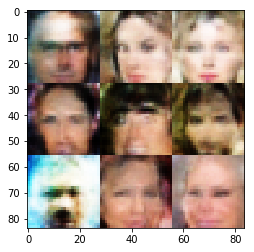

Epoch 2/4... Discriminator Loss: 0.9702146... Generator Loss: 0.9362312
Epoch 2/4... Discriminator Loss: 0.5632927... Generator Loss: 2.0271406
Epoch 2/4... Discriminator Loss: 0.5941259... Generator Loss: 1.7309926
Epoch 2/4... Discriminator Loss: 0.6079304... Generator Loss: 1.6645889
Epoch 2/4... Discriminator Loss: 0.4429773... Generator Loss: 4.0576444
Epoch 2/4... Discriminator Loss: 0.6566498... Generator Loss: 1.5921886
Epoch 2/4... Discriminator Loss: 0.6210037... Generator Loss: 1.6587038
Epoch 2/4... Discriminator Loss: 0.9336866... Generator Loss: 2.9428926
Epoch 2/4... Discriminator Loss: 0.7557760... Generator Loss: 2.2806129
Epoch 2/4... Discriminator Loss: 1.0146503... Generator Loss: 2.2815952


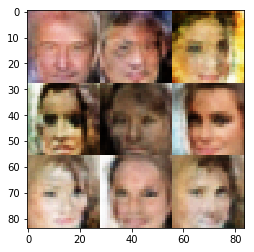

Epoch 2/4... Discriminator Loss: 0.8051822... Generator Loss: 3.9169426
Epoch 2/4... Discriminator Loss: 0.5140412... Generator Loss: 2.2316277
Epoch 2/4... Discriminator Loss: 0.5656954... Generator Loss: 2.6720490
Epoch 2/4... Discriminator Loss: 0.5508962... Generator Loss: 3.1113005
Epoch 2/4... Discriminator Loss: 0.6348628... Generator Loss: 1.6207085
Epoch 2/4... Discriminator Loss: 0.4740011... Generator Loss: 2.3392353
Epoch 2/4... Discriminator Loss: 0.4763868... Generator Loss: 2.7189810
Epoch 2/4... Discriminator Loss: 0.4305327... Generator Loss: 2.7120008
Epoch 2/4... Discriminator Loss: 0.3773782... Generator Loss: 3.8288717
Epoch 2/4... Discriminator Loss: 3.0279233... Generator Loss: 0.1286114


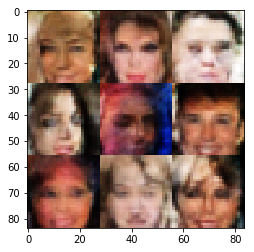

Epoch 2/4... Discriminator Loss: 1.0162237... Generator Loss: 1.4195346
Epoch 2/4... Discriminator Loss: 1.2029546... Generator Loss: 0.6905502
Epoch 2/4... Discriminator Loss: 0.6476806... Generator Loss: 1.8572428
Epoch 2/4... Discriminator Loss: 0.7581774... Generator Loss: 1.3142678
Epoch 2/4... Discriminator Loss: 0.9392741... Generator Loss: 0.9306825
Epoch 2/4... Discriminator Loss: 0.7165985... Generator Loss: 1.4301261
Epoch 2/4... Discriminator Loss: 0.7869278... Generator Loss: 1.2291279
Epoch 2/4... Discriminator Loss: 0.6878424... Generator Loss: 1.4037192
Epoch 2/4... Discriminator Loss: 1.2554233... Generator Loss: 0.6336623
Epoch 2/4... Discriminator Loss: 0.6267755... Generator Loss: 2.0646207


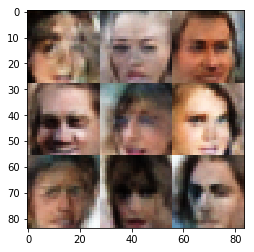

Epoch 2/4... Discriminator Loss: 0.5645008... Generator Loss: 1.7923598
Epoch 2/4... Discriminator Loss: 0.4530395... Generator Loss: 2.4686236
Epoch 2/4... Discriminator Loss: 0.4955095... Generator Loss: 3.0004447
Epoch 2/4... Discriminator Loss: 0.5610653... Generator Loss: 1.7872132
Epoch 2/4... Discriminator Loss: 0.4528197... Generator Loss: 3.2049236
Epoch 2/4... Discriminator Loss: 0.8965021... Generator Loss: 4.9640808
Epoch 2/4... Discriminator Loss: 1.2863598... Generator Loss: 0.6764960
Epoch 2/4... Discriminator Loss: 1.0281763... Generator Loss: 0.8360014
Epoch 2/4... Discriminator Loss: 0.7549847... Generator Loss: 1.4658197
Epoch 2/4... Discriminator Loss: 0.5495937... Generator Loss: 1.9838698


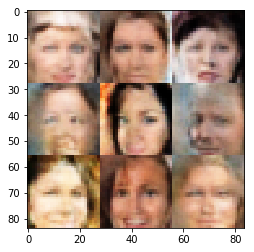

Epoch 2/4... Discriminator Loss: 0.5585113... Generator Loss: 1.9404314
Epoch 2/4... Discriminator Loss: 0.5375466... Generator Loss: 2.4003797
Epoch 2/4... Discriminator Loss: 0.4391949... Generator Loss: 2.7034149
Epoch 2/4... Discriminator Loss: 0.5443676... Generator Loss: 2.9559288
Epoch 2/4... Discriminator Loss: 0.6624972... Generator Loss: 1.7582619
Epoch 2/4... Discriminator Loss: 0.8377104... Generator Loss: 1.1574270
Epoch 3/4... Discriminator Loss: 1.3930626... Generator Loss: 0.6096230
Epoch 3/4... Discriminator Loss: 1.0092735... Generator Loss: 1.5773848
Epoch 3/4... Discriminator Loss: 0.6070454... Generator Loss: 2.2318659
Epoch 3/4... Discriminator Loss: 0.9524328... Generator Loss: 0.9412023


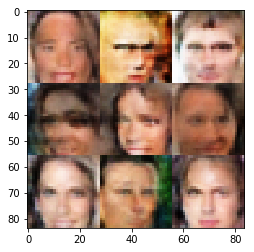

Epoch 3/4... Discriminator Loss: 0.5656499... Generator Loss: 2.1845784
Epoch 3/4... Discriminator Loss: 0.5288574... Generator Loss: 2.0926795
Epoch 3/4... Discriminator Loss: 0.6382006... Generator Loss: 1.5923613
Epoch 3/4... Discriminator Loss: 0.7980165... Generator Loss: 3.7209837
Epoch 3/4... Discriminator Loss: 1.0077466... Generator Loss: 0.9477895
Epoch 3/4... Discriminator Loss: 0.9599500... Generator Loss: 2.1509042
Epoch 3/4... Discriminator Loss: 0.4908442... Generator Loss: 2.7553747
Epoch 3/4... Discriminator Loss: 0.7166664... Generator Loss: 1.3449119
Epoch 3/4... Discriminator Loss: 0.4471356... Generator Loss: 2.7616186
Epoch 3/4... Discriminator Loss: 0.7648793... Generator Loss: 1.2285309


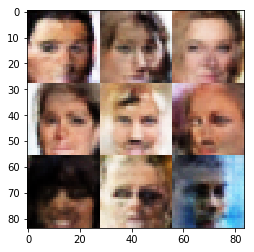

Epoch 3/4... Discriminator Loss: 0.6499223... Generator Loss: 1.4900289
Epoch 3/4... Discriminator Loss: 0.4054068... Generator Loss: 3.3399379
Epoch 3/4... Discriminator Loss: 0.6062376... Generator Loss: 3.6813354
Epoch 3/4... Discriminator Loss: 0.5876462... Generator Loss: 1.6854678
Epoch 3/4... Discriminator Loss: 0.4907165... Generator Loss: 3.3520083
Epoch 3/4... Discriminator Loss: 0.5158492... Generator Loss: 2.1733041
Epoch 3/4... Discriminator Loss: 0.8530310... Generator Loss: 1.0900660
Epoch 3/4... Discriminator Loss: 0.5584273... Generator Loss: 1.9017382
Epoch 3/4... Discriminator Loss: 0.4359900... Generator Loss: 3.1406522
Epoch 3/4... Discriminator Loss: 0.3711650... Generator Loss: 3.9413714


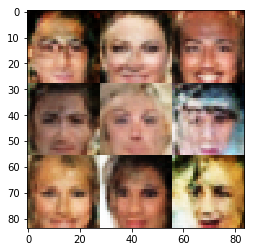

Epoch 3/4... Discriminator Loss: 1.1877260... Generator Loss: 0.7526327
Epoch 3/4... Discriminator Loss: 1.4818193... Generator Loss: 3.4267263
Epoch 3/4... Discriminator Loss: 0.9034921... Generator Loss: 2.4294865
Epoch 3/4... Discriminator Loss: 0.6114566... Generator Loss: 1.8959421
Epoch 3/4... Discriminator Loss: 0.7438688... Generator Loss: 1.3299367
Epoch 3/4... Discriminator Loss: 0.6399004... Generator Loss: 1.7354286
Epoch 3/4... Discriminator Loss: 0.6781945... Generator Loss: 2.6362484
Epoch 3/4... Discriminator Loss: 0.7630651... Generator Loss: 1.2788224
Epoch 3/4... Discriminator Loss: 0.7918653... Generator Loss: 1.1778502
Epoch 3/4... Discriminator Loss: 0.6562766... Generator Loss: 2.4653003


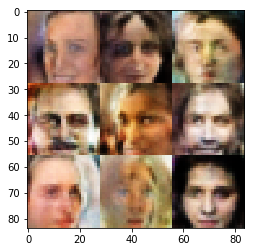

Epoch 3/4... Discriminator Loss: 0.6050594... Generator Loss: 2.1297336
Epoch 3/4... Discriminator Loss: 0.4953085... Generator Loss: 2.2069278
Epoch 3/4... Discriminator Loss: 0.5574599... Generator Loss: 1.9308261
Epoch 3/4... Discriminator Loss: 0.6957613... Generator Loss: 1.3903214
Epoch 3/4... Discriminator Loss: 0.5517060... Generator Loss: 2.7394056
Epoch 3/4... Discriminator Loss: 1.0991998... Generator Loss: 0.7596676
Epoch 3/4... Discriminator Loss: 1.3836206... Generator Loss: 0.5696156
Epoch 3/4... Discriminator Loss: 1.3375406... Generator Loss: 0.5574027
Epoch 3/4... Discriminator Loss: 0.9076055... Generator Loss: 1.0656432
Epoch 3/4... Discriminator Loss: 0.6396496... Generator Loss: 1.6593044


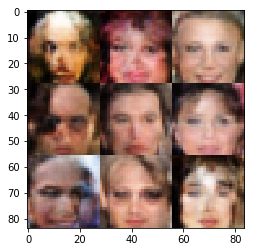

Epoch 3/4... Discriminator Loss: 0.6876365... Generator Loss: 1.5412740
Epoch 3/4... Discriminator Loss: 0.8141170... Generator Loss: 1.1205962
Epoch 3/4... Discriminator Loss: 0.5795630... Generator Loss: 1.7666053
Epoch 3/4... Discriminator Loss: 0.5112712... Generator Loss: 2.1349621
Epoch 3/4... Discriminator Loss: 0.4829658... Generator Loss: 4.0609679
Epoch 3/4... Discriminator Loss: 0.6436328... Generator Loss: 1.5219972
Epoch 3/4... Discriminator Loss: 0.4002039... Generator Loss: 3.2025721
Epoch 3/4... Discriminator Loss: 3.3847151... Generator Loss: 0.1070129
Epoch 3/4... Discriminator Loss: 1.0254420... Generator Loss: 0.8584592
Epoch 3/4... Discriminator Loss: 0.6971555... Generator Loss: 1.4721488


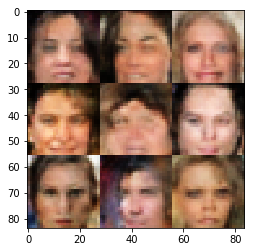

Epoch 3/4... Discriminator Loss: 1.2799431... Generator Loss: 0.6369154
Epoch 3/4... Discriminator Loss: 0.8121016... Generator Loss: 1.1858022
Epoch 3/4... Discriminator Loss: 0.5685074... Generator Loss: 1.8009090
Epoch 3/4... Discriminator Loss: 0.5591627... Generator Loss: 3.1102061
Epoch 3/4... Discriminator Loss: 0.6258835... Generator Loss: 1.5945919
Epoch 3/4... Discriminator Loss: 0.6758098... Generator Loss: 3.8135469
Epoch 3/4... Discriminator Loss: 0.5007313... Generator Loss: 2.1481102
Epoch 3/4... Discriminator Loss: 0.5211173... Generator Loss: 2.7807212
Epoch 3/4... Discriminator Loss: 0.9352096... Generator Loss: 4.2428131
Epoch 3/4... Discriminator Loss: 0.7211828... Generator Loss: 1.3951495


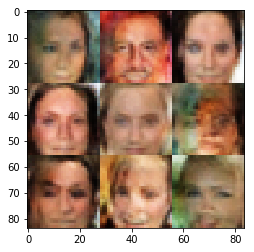

Epoch 3/4... Discriminator Loss: 0.5946133... Generator Loss: 1.7457098
Epoch 3/4... Discriminator Loss: 0.5362680... Generator Loss: 2.8240051
Epoch 3/4... Discriminator Loss: 0.4678286... Generator Loss: 2.3502707
Epoch 3/4... Discriminator Loss: 0.8184465... Generator Loss: 1.1469065
Epoch 3/4... Discriminator Loss: 0.8245696... Generator Loss: 3.7070947
Epoch 3/4... Discriminator Loss: 0.3805701... Generator Loss: 3.5612643
Epoch 3/4... Discriminator Loss: 0.5728772... Generator Loss: 1.8216320
Epoch 3/4... Discriminator Loss: 0.4876389... Generator Loss: 2.2792029
Epoch 3/4... Discriminator Loss: 0.5283147... Generator Loss: 2.2830763
Epoch 3/4... Discriminator Loss: 0.4598604... Generator Loss: 3.2334204


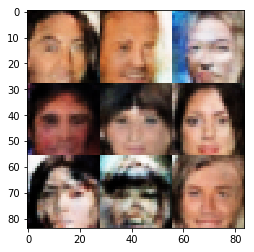

Epoch 3/4... Discriminator Loss: 0.4022417... Generator Loss: 3.9473591
Epoch 3/4... Discriminator Loss: 1.4851691... Generator Loss: 0.5488106
Epoch 3/4... Discriminator Loss: 0.8932593... Generator Loss: 2.6983643
Epoch 3/4... Discriminator Loss: 0.7371812... Generator Loss: 1.8159493


IndexError: list index out of range

In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.